In [1]:
# verify that we're using the correct version of StellarGraph for this notebook
import stellargraph as sg

try:
    sg.utils.validate_notebook_version("1.2.1")
except AttributeError:
    raise ValueError(
        f"This notebook requires StellarGraph version 1.2.1, but a different version {sg.__version__} is installed.  Please see <https://github.com/stellargraph/stellargraph/issues/1172>."
    ) from None

2022-02-02 18:57:14.910820: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /ihome/crc/install/cuda-11.1.1/pytorch/1.8.1_gpu/python3.8/lib:/usr/lib64:/ihome/crc/install/cuda/11.1.1/lib64/stubs:/ihome/crc/install/cuda/11.1.1/lib64
2022-02-02 18:57:14.910864: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1850] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2022-02-02 18:57:14.911352: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in perfo

In [2]:
!ls

dummy.xlsx  GCN-2.ipynb  GCN.ipynb


In [3]:
from stellargraph import StellarGraph
import json
import pandas as pd
import numpy as np
from sklearn import preprocessing, feature_extraction, model_selection
from sklearn.metrics import mean_absolute_error, mean_squared_error

import stellargraph as sg
from stellargraph.mapper import HinSAGELinkGenerator
from stellargraph.layer import HinSAGE, link_regression
from tensorflow.keras import Model, optimizers, losses, metrics

import multiprocessing
from stellargraph import datasets
from IPython.display import display, HTML
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
import pandas as pd

In [5]:
xl = pd.ExcelFile("dummy.xlsx")
df = xl.parse("Sheet1", header=None)
df.columns=["pathway","tfs"]
df=df.head()
df

,pathway,tfs
0,acute myeloid leukemia,"['STAT3', 'PRDM1']"
1,adipocytokine signaling pathway,"['STAT3', 'PRDM1']"
2,pancreatic cancer,"['STAT3', 'PRDM1']"
3,jak stat signaling pathway,"['STAT3', 'PRDM1']"
4,acute myeloid leukemia,"['STAT3', 'KLF5']"


In [66]:
df.tfs[1].__class__

str

In [67]:
import ast
for i in range(len(df)):
    x =df.tfs[i]
    x = ast.literal_eval(x)
    x = [n.strip() for n in x]
    df.tfs[i]=x


In [68]:
x.__class__

list

## NETWORKX

In [14]:
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd

In [15]:
 # Larger data preperation - SNA of Trump's Person-Person Edge List
# Edgelist & Adjacency list is created by myself with the dataset above
df1=pd.read_csv("file_for_network.csv",encoding = "ISO-8859-1", index_col=0)
df1
p_a=df1['Gene 1']
p_b=df1['Gene 2']
df2=pd.concat([p_a,p_b],axis=0)    
df2_l=df2.values.tolist() # To count the frequency of names
# Filter vertices - each one must know 2 or more people
output = [] # Get unique values 
for x in p_a:
    if x not in output:
        output.append(x)
for x in p_b:
    if x not in output:
        output.append(x)
#print (output)
df3=pd.DataFrame(output)
cnt=[]
for x in output:
    cnt.append(df2_l.count(x))
df3['cnt']=cnt # Add a new column of frequency of the names
df4=df3
df4=df4.drop(df3[df3.cnt>1].index) # Get the list the vertices with only 1 target
df4_l=df4[0].values.tolist()# list the vertices with only 1 target
# Drop the names who only know one person
for x in df4_l:
    df1=df1[~df1['Gene 1'].str.contains(x)]
    df1=df1[~df1['Gene 2'].str.contains(x)]
p_a1=df1['Gene 1'].values.tolist()
p_b1=df1['Gene 2'].values.tolist()
output2 = [] # Get unique values again
for x in p_a1:
    if x not in output2:
        output2.append(x)
for x in p_b1:
    if x not in output2:
        output2.append(x)

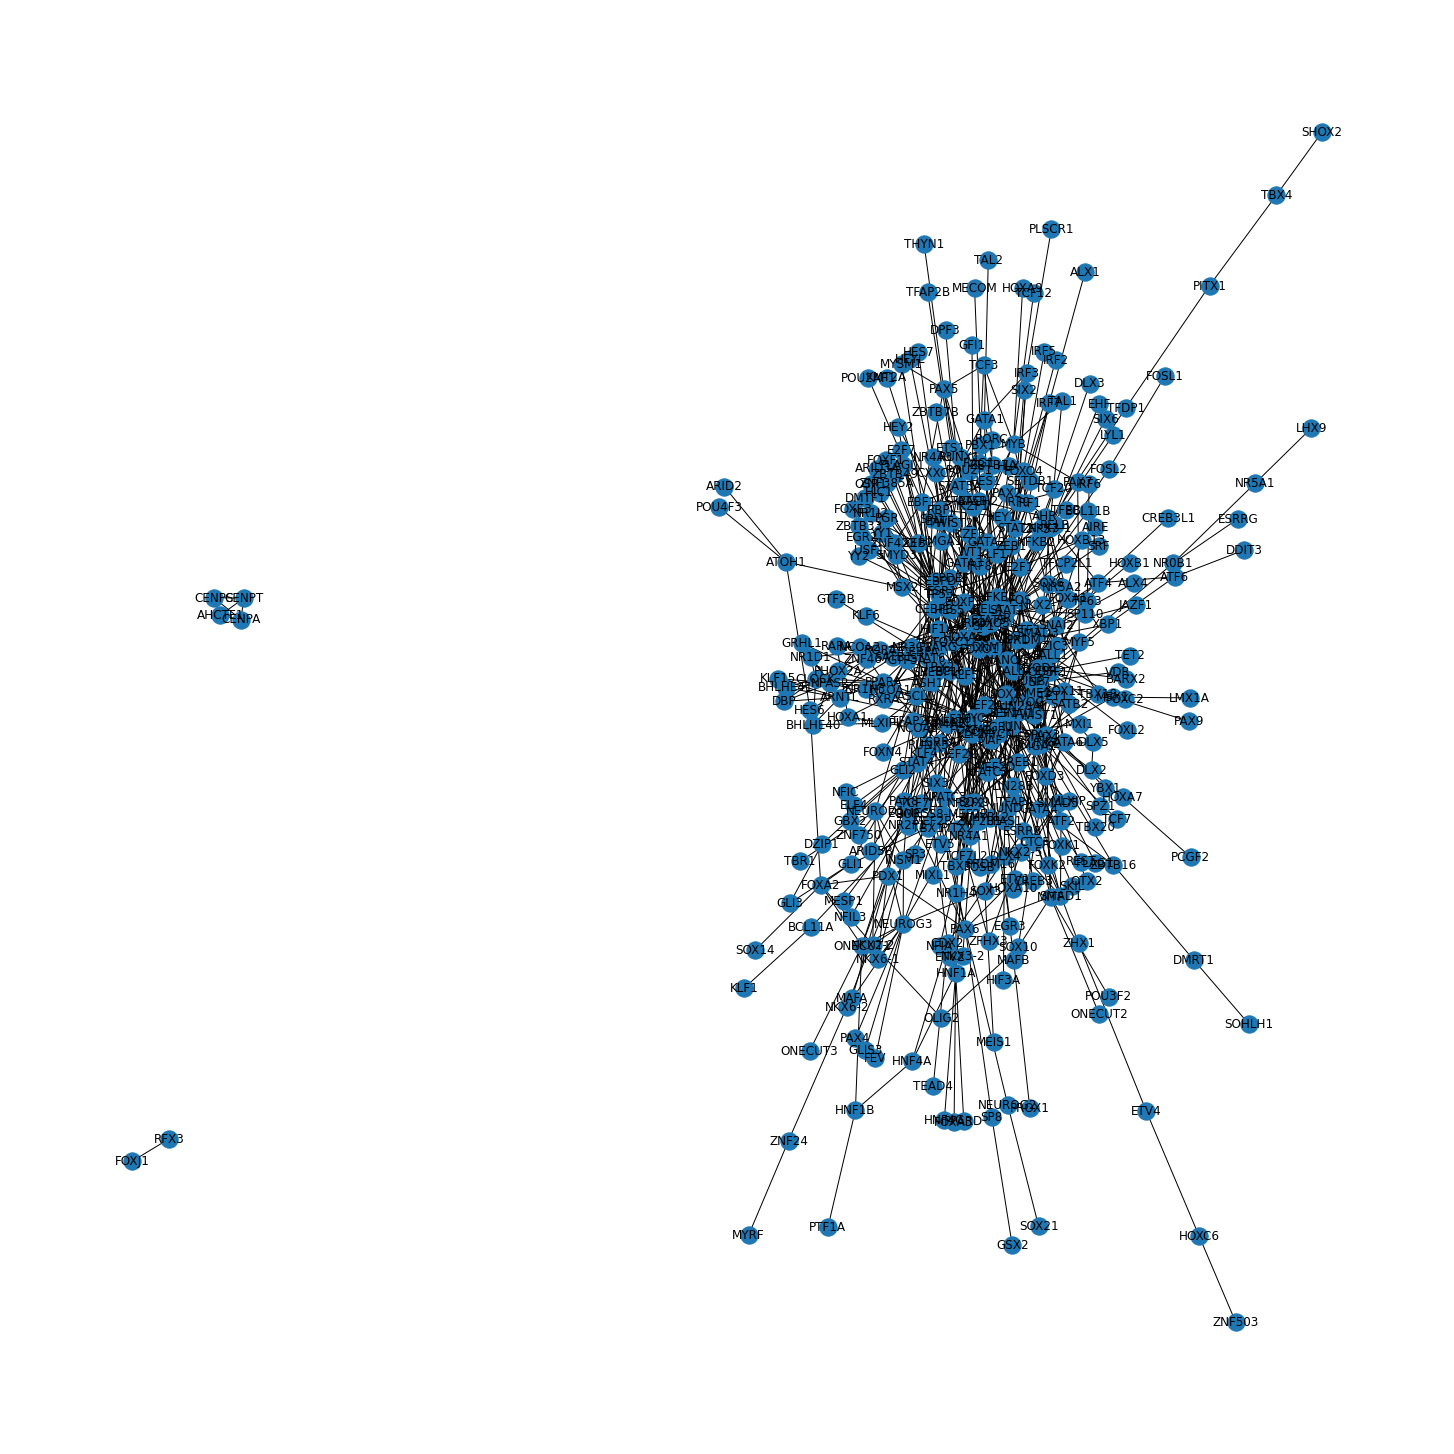

In [24]:
## networkx - edgelist
l=list(zip(p_a1,p_b1)) # EDGELIST
NetxG1 = nx.Graph()
NetxG1.add_nodes_from(output2)
NetxG1.add_edges_from(l)
#print(list(NetxG1.nodes))
#print(list(NetxG1.edges))
plt.figure(figsize=(20,20)) 
nx.draw(NetxG1,with_labels=True)
plt.savefig('foo.png')
plt.savefig('foo.pdf')
plt.show()

In [ ]:
## networkx - weighted edges & arrows
weights=[]
for x in range(len(p_a1)):
    m=df3.loc[df3[0] == p_a1[x],'cnt'].iloc[0]
    n=df3.loc[df3[0] == p_b1[x],'cnt'].iloc[0]
    mn=0.05*m/10*n
    weights.append(mn)
weighted_eg=[]
for i in range(len(l)): # Create a weighted edge list
    weighted_eg.append([l[i][0],l[i][1],weights[i]])
NetxG3=nx.DiGraph()
NetxG3.add_weighted_edges_from(weighted_eg)
plt.figure(figsize=(30,30)) 
nx.draw(NetxG3,with_labels=True,width=weights,arrowsize=20)
plt.show()

In [20]:
square_named = StellarGraph.from_networkx(
    NetxG1, node_type_default="tf", edge_type_default="cascade"
)
print(square_named.info())

StellarGraph: Undirected multigraph
 Nodes: 376, Edges: 783

 Node types:
  tf: [376]
    Features: none
    Edge types: tf-cascade->tf

 Edge types:
    tf-cascade->tf: [783]
        Weights: all 1 (default)
        Features: none


In [23]:
plt.savefig('foo.png')
plt.savefig('foo.pdf')

<Figure size 432x288 with 0 Axes>

In [21]:
plt.show()